In [346]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import torch
import astropy.units as u
import seaborn as sns

from typing import Tuple
from astropy.io import fits, ascii
from astropy.coordinates import SkyCoord, Angle, concatenate
from sklearn.model_selection import train_test_split
from neural_net import normalize_arr, get_model, CustomLoss, resume
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score

import matplotlib as mpl
plt.rc('text', usetex=True)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed

PATH_TO_CLEAN_DATA = '/Users/adamboesky/Research/ay98/clean_data'

# Get Data

In [347]:
with open(f'/Users/adamboesky/Research/ay98/clean_data/all_cat.pkl', 'rb') as f:
    final_cat = pickle.load(f)

with open(f'/Users/adamboesky/Research/ay98/clean_data/all_photometry.pkl', 'rb') as f:
    final_photo = pickle.load(f)

In [348]:
# functions used for getting the coords given an id
def get_coords_for_id(gal_id: np.bytes_, lookup_table_path: str = '/Users/adamboesky/Research/ay98/clean_data/coord_lookup_table.pkl') -> Tuple[float, float]:
    """Function used to get the coordinates of a given tractor ID."""
    with open(lookup_table_path, 'rb') as f:
        coord_lookup_table = pickle.load(f)
    return coord_lookup_table[coord_lookup_table['gal_id'] == gal_id][0][1], coord_lookup_table[coord_lookup_table['gal_id'] == gal_id][0][2]


def get_coords_for_ids(gal_ids: np.bytes_, lookup_table_path: str = '/Users/adamboesky/Research/ay98/clean_data/coord_lookup_table.pkl') -> Tuple[float, float]:
    """Function used to get the coordinates of a given tractor ID."""
    with open(lookup_table_path, 'rb') as f:
        coord_lookup_table = pickle.load(f)

    sorted_inds = np.argsort(coord_lookup_table['gal_id'])
    lup_tab_sorted = coord_lookup_table[sorted_inds]
    print('Sorted')
    
    # Find the sorted indices of 'a' in 'b'
    indices_in_b_sorted = np.searchsorted(lup_tab_sorted['gal_id'], gal_ids, side='left')
    print('Search complete')
    
    # Make sure that all elements of 'a' are actually present in 'b'
    indices_in_b_sorted = indices_in_b_sorted[indices_in_b_sorted < len(coord_lookup_table['gal_id'])]
    valid_mask = lup_tab_sorted['gal_id'][indices_in_b_sorted] == gal_ids
    indices_in_b_sorted = indices_in_b_sorted[valid_mask]
    print('Validation complete')

    # Take the sorted indices and map back to original indices in 'b'
    all_indices = lup_tab_sorted[indices_in_b_sorted]
    
    return all_indices

In [349]:
with open('/Users/adamboesky/Research/ay98/clean_data/sn_coords_clean.csv', 'rb') as f:
    sne = pickle.load(f)

# Get sne type and host props

## Zou

In [84]:
# Find the host coordinates of all the sne without host coordinates already
sne_names = sne['name'].to_numpy()                  # array of sne names
host_coords = sne[['hostra', 'hostdec']]            # host coordst array
sne_coords = sne[['ra', 'dec']]                     # sne coords array

# Convert everything to np arrays
sne_coords = sne_coords.to_numpy()
host_coords = host_coords.to_numpy()

# Get list of sky coordinates objects for sne with no host and complete sne coords
sne_ra = []
sne_dec = []
for ra, dec in sne_coords:
    dec_ang = Angle(f'{dec.split(",")[0]} degrees')
    ra_ang = Angle(ra.split(',')[0], unit='hourangle')

    sne_ra.append(ra_ang.wrap_at("24h").deg)
    sne_dec.append(dec_ang.deg)

# Add coords to the df
sn_sky_coords = SkyCoord(sne_ra * u.deg, sne_dec * u.deg, frame='icrs')
sne['sky_coord'] = sn_sky_coords

In [24]:
# The centers of the three deep fields
wcdfs_center = SkyCoord(Angle('03:32:09', unit='hourangle').deg * u.deg, Angle('-28:08:32 degrees').deg * u.deg, frame='icrs')
es1_center = SkyCoord(Angle('00:37:47', unit='hourangle').deg * u.deg, Angle('-44:00:07 degrees').deg * u.deg, frame='icrs')
xmmlss_center = SkyCoord(Angle('02:22:10', unit='hourangle').deg * u.deg, Angle('-04:45:00 degrees').deg * u.deg, frame='icrs')

# Get the seperation of each SN from the center of the field
field_seps = np.zeros((len(sn_sky_coords), 3))
for i, field_center in enumerate((wcdfs_center, es1_center, xmmlss_center)):
    field_seps[:, i] = field_center.separation(sn_sky_coords).degree
min_sep = np.min(field_seps, axis=1)
print(min_sep)
print(np.min(min_sep))

[106.4619733  106.15641833 106.46747375 ...   7.32107933  43.03772154
 126.48246176]
0.07885258304887599


In [25]:
max_field_raidus = 4  # 1.3 is the approximate radius of the depe field, but we'll use 4 to be conservative
in_field_mask = min_sep < max_field_raidus
classified_mask = sne[in_field_mask]['claimedtype'] != 'Candidate'
nan_mask = sne[in_field_mask][classified_mask]['claimedtype'].to_numpy().astype(str) == 'nan'
print(f'There are {np.sum(in_field_mask)} supernovae within the deep fields.')
print(f"Of those, approximate {len(sne[in_field_mask][classified_mask]['claimedtype'].dropna())} are classified.")
print(f"Of the classified, {sne['claimedtype'][in_field_mask][classified_mask].str.contains('ia', case=False, na=False).sum() / len(sne[in_field_mask][classified_mask]['claimedtype'].dropna())} are type Ia")
classified_field_sne = sne[in_field_mask][classified_mask][~nan_mask]

There are 965 supernovae within the deep fields.
Of those, approximate 586 are classified.
Of the classified, 0.7491467576791809 are type Ia


In [27]:
gal_coords_arr = get_coords_for_ids(final_photo['gal_id'], lookup_table_path='/Users/adamboesky/Research/ay98/clean_data/coord_lookup_table.pkl')
gal_coords = SkyCoord(gal_coords_arr['RA'] * u.deg, gal_coords_arr['DEC'] * u.deg, frame='icrs')
smallest_seps = np.array([None for _ in range(len(classified_field_sne))])
hosts_30 = np.array([None for _ in range(len(classified_field_sne))])
hosts_60 = np.array([None for _ in range(len(classified_field_sne))])

# For each supernova, find the host galaxy
for i, coord in enumerate(concatenate(classified_field_sne['sky_coord'])):
    gal_seps = coord.separation(gal_coords).arcsec
    smallest_sep = np.min(gal_seps)
    smallest_sep_ind = np.argmin(gal_seps)
    if smallest_sep < 30:  # Host if the host is less than a 30 arcsec separation
        hosts_30[i] = final_cat['gal_id'][smallest_sep_ind]
        smallest_seps[i] = smallest_sep
    if smallest_sep < 60:  # Host if the host is less than a 30 arcsec separation
        hosts_60[i] = final_cat['gal_id'][smallest_sep_ind]

Sorted
Search complete
Validation complete


In [29]:
# Append host info
classified_field_sne['host'] = hosts_30
classified_field_sne['host_angular_sep_arcsec'] = smallest_seps
classified_field_sne[['event', 'catalog', 'claimedtype', 'host', 'host_angular_sep_arcsec']].head(-10)

# Make nice dictionary of galaxies, sne, and type
type_id_dist = classified_field_sne[['claimedtype', 'host', 'host_angular_sep_arcsec']].dropna().to_numpy()
gal_sne_types = {}
for sne_type, gal_tid, dist in type_id_dist:
    if gal_sne_types.get(gal_tid):
        gal_sne_types[gal_tid].append((sne_type, dist))
    else:
        gal_sne_types[gal_tid] = [(sne_type, dist)]

In [34]:
# Load and preprocess the data for the NN
with open(os.path.join(PATH_TO_CLEAN_DATA, 'all_photometry.pkl'), 'rb') as f:
    all_photo = pickle.load(f)
photo = all_photo['data']
photo_err = all_photo['data_err']

# Take log of the fluxes to make the distributions better
photo_err = np.abs(photo_err / (photo * np.log(10)))
photo = np.log10(photo)

with open(os.path.join(PATH_TO_CLEAN_DATA, 'all_cat.pkl'), 'rb') as f:
    all_cat = pickle.load(f)
cat = all_cat['data']
print(f'Fixing the error for {np.sum(all_cat["data_err"][:, 2] == 0.01)} objects')
all_cat['data_err'][:, 2][all_cat['data_err'][:, 2] == 0.01] = 0.001 # Drop the spectroscopic errors down from the already low error
cat_err = all_cat['data_err']

print('Importing photometry data')
# Filter out z>1
z_local_mask = cat[:, 2] <= 1
photo = photo[z_local_mask]
photo_err = photo_err[z_local_mask]
cat = cat[z_local_mask]
cat_err = cat_err[z_local_mask]


######################## PRE PROCESSING ########################
# Filter out nans
nan_mask = np.isnan(cat).any(axis=1)
photo_norm, photo_mean, photo_std, photo_err_norm = normalize_arr(photo[~nan_mask], errors=photo_err[~nan_mask])
cat_norm, cat_mean, cat_std, cat_err_norm = normalize_arr(cat[~nan_mask], errors=cat_err[~nan_mask])
print('HEEERRRREE', cat_norm)
print(cat_mean)
print(f'Photo stats:\n \tmean = {photo_mean}\n \tstd = {photo_std}')
print(f'Catalog stats:\n \tmean = {cat_mean}\n \tstd = {cat_std}')
print(f'Length = {len(photo)}')

Fixing the error for 96514 objects
Importing photometry data
HEEERRRREE [[ 0.70927392  1.25512957  0.2270539 ]
 [-0.33256743  0.67634887  0.87570289]
 [-0.2748967   0.76784266  0.57368643]
 ...
 [ 0.60130756 -0.66104664  0.7521507 ]
 [-1.06907597 -0.30847975 -0.19851475]
 [-0.32610561 -0.29959755 -0.82657171]]
[ 8.69840122 -0.65829206  0.56184221]
Photo stats:
 	mean = [-2.88750664 -2.80485236 -2.79177703 -2.64890962 -2.69422682 -1.33202668
  0.06717019  0.67723176  1.35547094  0.92884049  1.34127727  1.21686633
  1.33390055 -2.42786271 -2.2128036  -1.99193711 -3.04366902 -3.0434582 ]
 	std = [0.6256189  0.69351311 0.67564669 0.71696901 0.78423232 0.88506622
 1.62868632 2.06807325 0.43284611 1.35729201 0.49397298 0.43336611
 0.45556757 2.21415807 2.12945886 2.02186998 0.66726908 0.69343955]
Catalog stats:
 	mean = [ 8.69840122 -0.65829206  0.56184221]
 	std = [1.31209275 1.35189867 0.29137484]
Length = 1261630


In [36]:
# Get best model based on grid search
n_epochs = 1000
nodes_per_layer = [18, 15, 12, 9, 6, 4]
num_linear_output_layers = 3
learning_rate = 0.01
batch_size = 4096
torch.set_default_dtype(torch.float64)
model = get_model(num_inputs=18, num_outputs=3, nodes_per_layer=nodes_per_layer, num_linear_output_layers=num_linear_output_layers)
loss_fn = CustomLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
resume(model, '/Users/adamboesky/Research/ay98/Weird_Galaxies/best_model.pkl')
model.eval()


# Predict attributes for the galaxies that have SNe
has_sne_mask = np.isin(all_photo['gal_id'][z_local_mask], list(gal_sne_types.keys()))
photo_norm_sne, photo_err_norm_sne = photo_norm[has_sne_mask], photo_err_norm[has_sne_mask]
cat_norm_sne, cat_err_norm_sne = cat_norm[has_sne_mask], cat_err_norm[has_sne_mask]
model.eval()
gal_props_pred: torch.Tensor = model(torch.from_numpy(photo_norm_sne))
gal_props_pred_untrans = gal_props_pred.detach().numpy()

In [276]:
# Filter the values that only appear once
tids, counts = np.unique(final_photo['gal_id'], return_counts=True)
unique_tids = tids[counts == 1]
too_many_tids = tids[counts > 1]

# Get the attributes of the hosts for all the SNe
host_inds = []
sne_props = []
n_not_found = 0
n_multiple_tids = 0
for sn in type_id_dist:
    idx = np.where(final_photo['gal_id'][z_local_mask][has_sne_mask] == sn[1])[0]
    if len(idx) == 1 and sn[1] in unique_tids:  # drop them if the 
        sne_props.append(sn)
        host_inds.append(idx[0])
    elif sn[1] in too_many_tids:
        n_multiple_tids += 1
    elif len(idx) == 0:
        n_not_found += 1

sne_props = np.hstack((sne_props, gal_props_pred_untrans[host_inds]))
sne_props_true = np.hstack((sne_props, cat_norm[has_sne_mask][host_inds]))
print(f'Filtering for z<1 dropped us from {len(type_id_dist)} to {len(sne_props)}. {n_not_found} were dropped because they are z>1 and {n_multiple_tids} dropped because there were multiple tractor IDs for the host. ------This issue was fixed by adding the gal_id identifier :)!!!')
print(f'SNe data is in the form (sne_type, host_gal_id, angular_dist_to_host, log_mass, log_sfr, redshift)')

Filtering for z<1 dropped us from 324 to 289. 35 were dropped because they are z>1 and 0 dropped because there were multiple tractor IDs for the host. ------This issue was fixed by adding the gal_id identifier :)!!!
SNe data is in the form (sne_type, host_gal_id, angular_dist_to_host, log_mass, log_sfr, redshift)


In [39]:
sne_props[:, 3:] = sne_props[:, 3:] * cat_std + cat_mean

In [ ]:
# Ia, II, or other
print('Before:\n', sne_props[:, 0])

# Conditions to check for 'ii' or 'ia' in a case-insensitive manner
condition_ii = np.vectorize(lambda s: 'ii' in s.lower())
condition_ia = np.vectorize(lambda s: 'ia' in s.lower())

# Apply conditions and choices to the string array
sne_props[:, 0] = np.where(condition_ia(sne_props[:, 0]), 0, np.where(condition_ii(sne_props[:, 0]), 1, 2))
print('After:\n', sne_props[:, 0])
print(f'The data are {np.round(100*len(sne_props[:, 0][sne_props[:, 0] == 0]) / len(sne_props), decimals=3)}% type Ia')

In [40]:
# Ia or other
print('Before:\n', sne_props[:, 0])
ia_mask = np.char.find(np.char.lower(np.array([str(item) for item in sne_props[:, 0]], dtype=str)), 'ia') != -1
sne_props[:, 0] = ia_mask.astype(int)
sne_props_true[:, 0] = ia_mask.astype(int)
print('After:\n', sne_props[:, 0])
print(f'The data are {np.round(100*len(sne_props[:, 0][sne_props[:, 0] == 1]) / len(sne_props), decimals=3)}% type Ia')

Before:
 ['Ia' 'Ia' 'Ic' 'Ia' 'Ia,Ia-91T' 'Ia' 'II' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia'
 'Ia' 'II' 'II' 'Ia' 'Ia' 'Ia' 'Ic' 'II' 'Ia' 'Ia' 'II' 'Ia' 'Ia' 'Ia'
 'Ia' 'Ia' 'SLSN-I,SLSN' 'Ia' 'Ia' 'Ia?' 'II?' 'Ia' 'Ia' 'Ia' 'SLSN-I'
 'Ia?' 'Ia?' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ib/c' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?,Ia'
 'Ia' 'Ib/c' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?' 'Ia' 'Ia' 'Ia'
 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?' 'II' 'Ia' 'Ia?'
 'SLSN-I' 'Ia' 'Ia' 'Ia' 'II' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia'
 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'II' 'Ia' 'Ia' 'Ia' 'Ia' 'Ib/c'
 'Ia' 'II?' 'Ia' 'II' 'Ia?' 'Ia Pec' 'Ia?' 'Ia?' 'Ia' 'II?' 'Ia' 'Ia' 'Ia'
 'Ia' 'Ia' 'Ia' 'Ia?' 'Ia' 'II' 'II' 'Ia' 'Ia?' 'II' 'Ia' 'Ia?' 'Ia' 'Ia'
 'Ia?' 'Ia?' 'Ia' 'Ia' 'Ia' 'Ia?' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'II?' 'Ia' 'Ia'
 'Ia' 'Ia' 'Ia' 'II' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?' 'SLSN-I?' 'II' 'Ia' 'Ia'
 'Ia?' 'Ia' 'II?' 'Ia' 'Ia?' 'II?' 'Ia' 'Ia' 'Ia?' 'Ia' 'Ib/c?' 'II' 'Ia'
 'Ia,Ia' 'Ia' 'IIn' 'Ia' 'II P,II' 'Ia?' 

In [49]:
# Split train and test data
sne_props = sne_props.astype(float)
sne_props_X = sne_props[:, 2:]
sne_props_y = sne_props[:, 0]
sne_props_train, sne_props_test = train_test_split(sne_props, test_size=0.2, random_state=22)
sne_props_train_X = sne_props_train[:, 2:]
sne_props_train_y= sne_props_train[:, 0]
sne_props_test_X = sne_props_test[:, 2:]
sne_props_test_y= sne_props_test[:, 0]
sne_props_X = sne_props[:, 2:]
sne_props_y = sne_props[:, 0]

# Split train and test data
sne_props_true = sne_props_true.astype(float)
sne_props_true_X = sne_props_true[:, 2:]
sne_props_true_y = sne_props_true[:, 0]

In [70]:
# Define the pipeline
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parameters for GridSearchCV
param_grid = {
    'classifier__max_depth': list(np.linspace(2, 31, num=30).astype(int)) + [None]  # List depths you want to test
}

# Get grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(sne_props_X, sne_props_y)
best_max_depth = grid_search.best_params_['classifier__max_depth']
print("Best max depth:", best_max_depth)

Best max depth: 12


### Stratified K-Fold CV

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_72237/2144283338.py:66: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


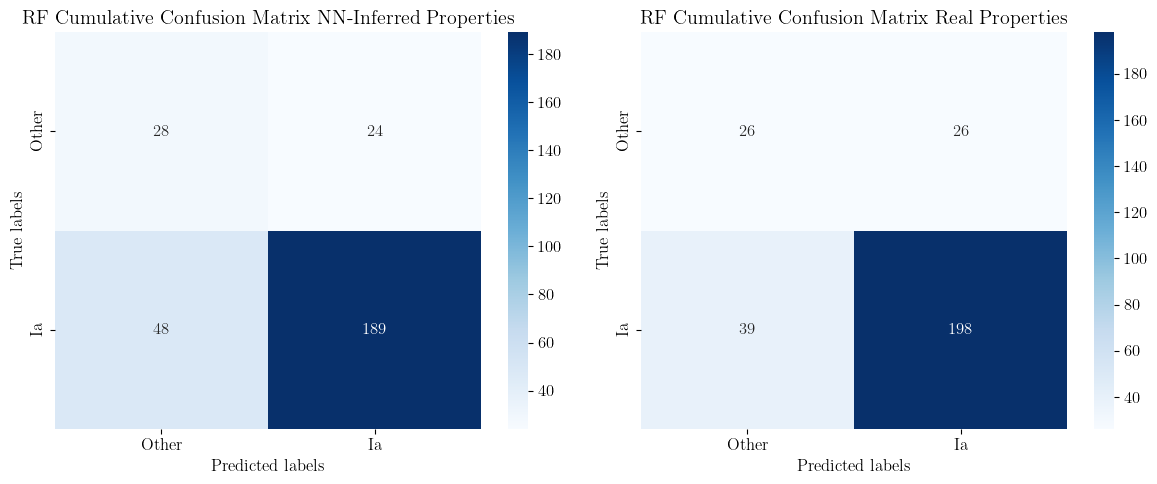

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_72237/2144283338.py:96: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


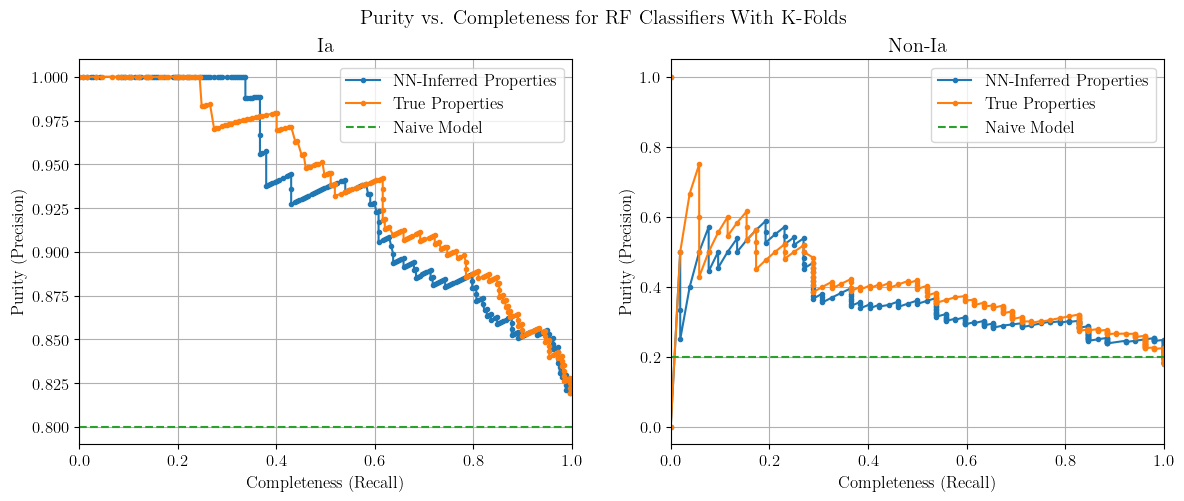

In [338]:
# K fold confusion matrix
kf = StratifiedKFold(n_splits=50, random_state=22, shuffle=True)
smote = SMOTE(random_state=22)
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=22, max_depth=best_max_depth)

# Initialize a matrix to hold the summed confusion matrix
cumulative_cm = np.array([[0, 0], [0, 0]])
cumulative_cm_true = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights_true = np.array([[0, 0], [0, 0]])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests = []
y_proba = []
y_tests_true = []
y_proba_true = []
f1_scores = []

# Iterate over each fold
for train_index, test_index in kf.split(sne_props_X, sne_props_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = sne_props_X[train_index], sne_props_X[test_index]
    y_train, y_test = sne_props_y[train_index], sne_props_y[test_index]

    # Do SMOTE resampling
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    cumulative_cm += confusion_matrix(y_test, y_pred)
    
    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    y_tests.append(y_test)
    y_proba.append(y_pred_proba)


    ### TRUE DERIVED DATA ###
    # Split the data into training and test sets for the current fold
    X_true_train, X_true_test = sne_props_true_X[train_index], sne_props_true_X[test_index]
    y_true_train, y_true_test = sne_props_true_y[train_index], sne_props_true_y[test_index]

    # Do SMOTE resampling
    X_true_train, y_true_train = smote.fit_resample(X_true_train, y_true_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier.fit(X_true_train, y_true_train)
    y_true_pred = rf_classifier.predict(X_true_test)
    cumulative_cm_true += confusion_matrix(y_true_test, y_true_pred)

    # Get the info for the purity vs. completeness curve
    y_pred_proba_true = rf_classifier.predict_proba(X_true_test)[:, 1]
    y_tests_true.append(y_true_test)
    y_proba_true.append(y_pred_proba_true)

    # Get the f1 score
    f1 = f1_score(y_test, y_pred, average='binary')  # Adjust the 'average' parameter as needed
    f1_scores.append(f1)

# PLOTTING CONFUSION MATRICES
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cumulative_cm, ax=ax1, annot=True, fmt='d', cmap='Blues', xticklabels=['Other', 'Ia'], yticklabels=['Other', 'Ia'])
sns.heatmap(cumulative_cm_true, ax=ax2, annot=True, fmt='d', cmap='Blues', xticklabels=['Other', 'Ia'], yticklabels=['Other', 'Ia'])
ax1.set_title('RF Cumulative Confusion Matrix NN-Inferred Properties')
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax2.set_title('RF Cumulative Confusion Matrix Real Properties')
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
plt.tight_layout()
plt.show()


# PLOTTING PURITY V. COMPLETION CURVES
# Concatenate the true labels and probabilities from each fold
y_tests = np.concatenate(y_tests)
y_proba = np.concatenate(y_proba)
y_tests_true = np.concatenate(y_tests_true)
y_proba_true = np.concatenate(y_proba_true)

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_tests, y_proba)
precision_true, recall_true, thresholds_true = precision_recall_curve(y_tests_true, y_proba_true)

# Calculate precision and recall for non-Ia predictions by inverting the probabilities and labels
precision_0, recall_0, thresholds_0 = precision_recall_curve(y_tests, 1 - y_proba, pos_label=0)
precision_true_0, recall_true_0, thresholds_true_0 = precision_recall_curve(y_tests_true, 1 - y_proba_true, pos_label=0)

# Plotting purity vs. completeness
# Ia
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(recall, precision, marker='.', label='NN-Inferred Properties')
ax1.plot(recall_true, precision_true, marker='.', label='True Properties')
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax1.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Naive Model')
ax1.grid()
# Non-Ia
ax2.plot(recall_0, precision_0, marker='.', label='NN-Inferred Properties')
ax2.plot(recall_true_0, precision_true_0, marker='.', label='True Properties')
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Naive Model')
ax2.grid()

# Format
ax1.set_xlabel('Completeness (Recall)')
ax1.set_ylabel('Purity (Precision)')
ax1.set_xlim((0, 1))
plt.suptitle('Purity vs. Completeness for RF Classifiers With K-Folds')
ax1.set_title('Ia')
ax1.legend()
ax2.set_xlabel('Completeness (Recall)')
ax2.set_ylabel('Purity (Precision)')
ax2.set_xlim((0, 1))
ax2.set_title('Non-Ia')
ax2.legend()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_72237/3559133637.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_72237/3559133637.py:72: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


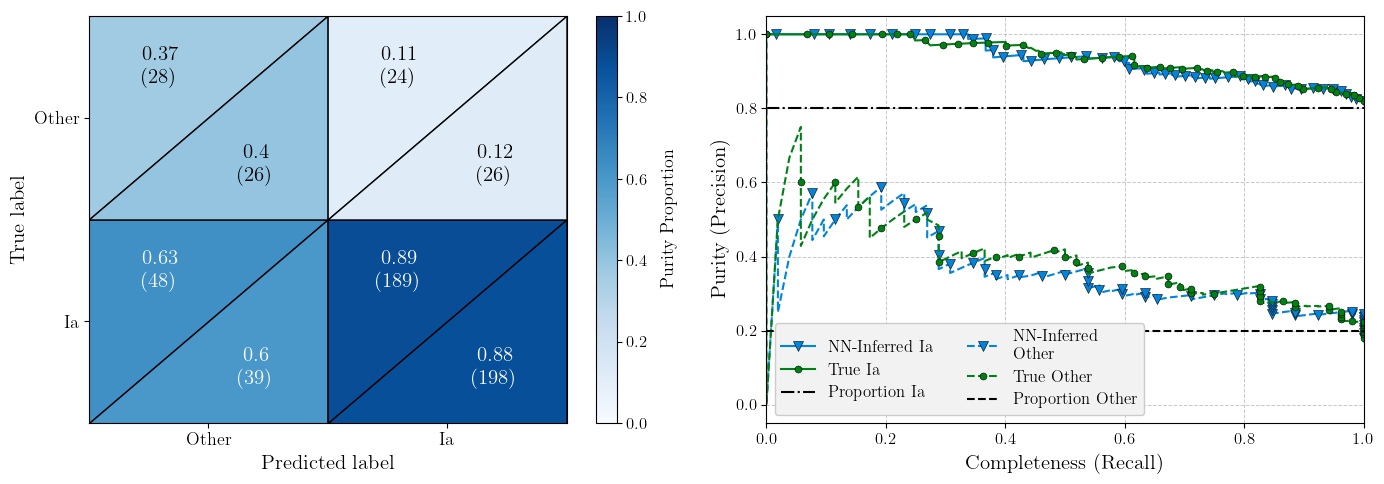

In [334]:
from matplotlib.cm import ScalarMappable

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm1 = np.flipud(cumulative_cm)
cm2 = np.flipud(cumulative_cm_true)

# Choose a colormap
cmap = plt.cm.Blues

# Define the bounds of the boxes
bounds = [0, 1, 2]

# Create a mesh grid
X, Y = np.meshgrid(bounds, bounds)

# Get the confusion normalized matrices
cm1_col_norms = np.sum(cm1, axis=0)
cm2_col_norms = np.sum(cm2, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm2_norm = cm2 / cm2_col_norms
cm1_norm = cm1_norm.round(2)
cm2_norm = cm2_norm.round(2)


# Normalize the values for the colormap
norm = plt.Normalize(vmin=0, vmax=1)


for (i, j), z in np.ndenumerate(cm1):
    # Color for the top triangle (cm1)
    color1 = cmap(norm(cm1_norm[i, j]))

    # Color for the bottom triangle (cm2)
    color2 = cmap(norm(cm2_norm[i, j]))

    # Split each cell diagonally
    # x1, y1 = i, j
    # x2, y2 = i+1, j+1
    # x3, y3 = i, j+1
    # x4, y4 = i + 1, j
    # # [x1, x3], [y1, y3], [y2, y2]
    ax1.fill_between([j, j+1], [i, i+1], [i+1, i+1], color=color1, edgecolor='black')
    ax1.fill_between([j, j+1], [i, i+1], [i, i], color=color2, edgecolor='black')

    # Add text
    if cm1_norm[i, j] > 0.5*norm.vmax: col1 = 'white'
    else: col1 = 'k'
    if cm1_norm[i, j] > 0.5*norm.vmax: col2 = 'white'
    else: col2 = 'k'
    ax1.text(j + 0.3, i + 0.75, '{}\n({})'.format(cm1_norm[i, j], cm1[i, j]), ha='center', va='center', fontsize=15, color=col1)
    ax1.text(j + 0.7, i + 0.27, '{}\n({})'.format(cm2_norm[i, j], cm2[i, j]), ha='center', va='center', fontsize=15, color=col1)

# Set the limits and labels
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(["Other", "Ia"])
ax1.set_yticklabels(["Ia", "Other"])
ax1.tick_params(axis='both', which='major', labelsize=13)  # Adjust labelsize as needed

# Add grid, labels and title
ax1.grid(False)
ax1.set_ylabel('True label', fontsize=15)
ax1.set_xlabel('Predicted label', fontsize=15)

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=13)



# Ia
ax2.plot(recall, precision, marker='v', label='NN-Inferred Ia', color='#0084DD', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true, precision_true, marker='.', label='True Ia', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='-.', label='Proportion Ia', color='k')
# Non-Ia
ax2.plot(recall_0, precision_0, marker='v', label='NN-Inferred \nOther', color='#0084DD', linestyle='--', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true_0, precision_true_0, marker='.', label='True Other', linestyle='--', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Proportion Other', color='k')
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)

# Format
ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.set_xlim((0, 1))
ax2.legend(fancybox=True, loc='lower left', ncol=2, framealpha=1, facecolor='#F2F2F2')
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/k_fold_results.png', dpi=1000)
plt.show()

### Leave One Out CV

1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289
1 / 289


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_72237/1510907101.py:66: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


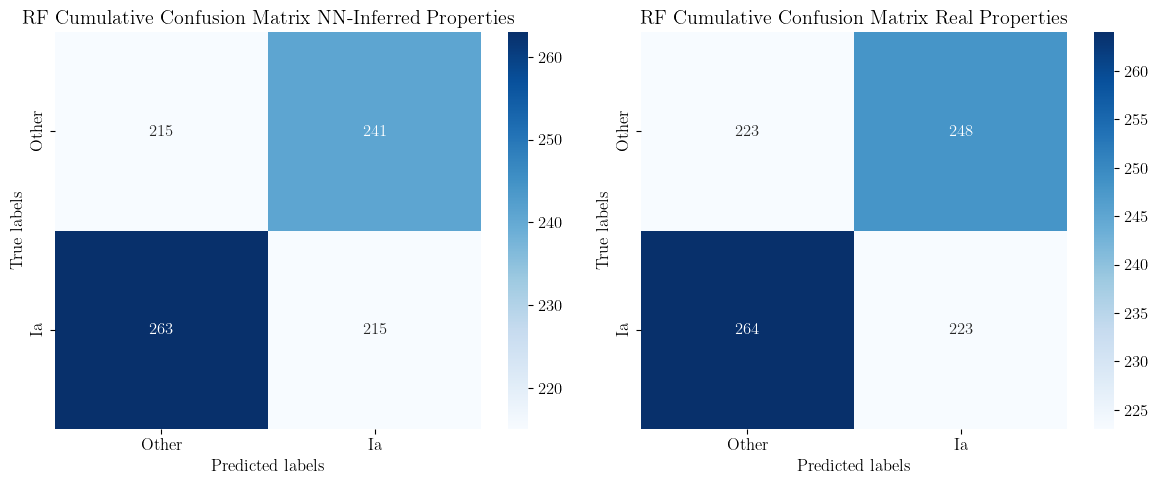

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_72237/1510907101.py:96: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


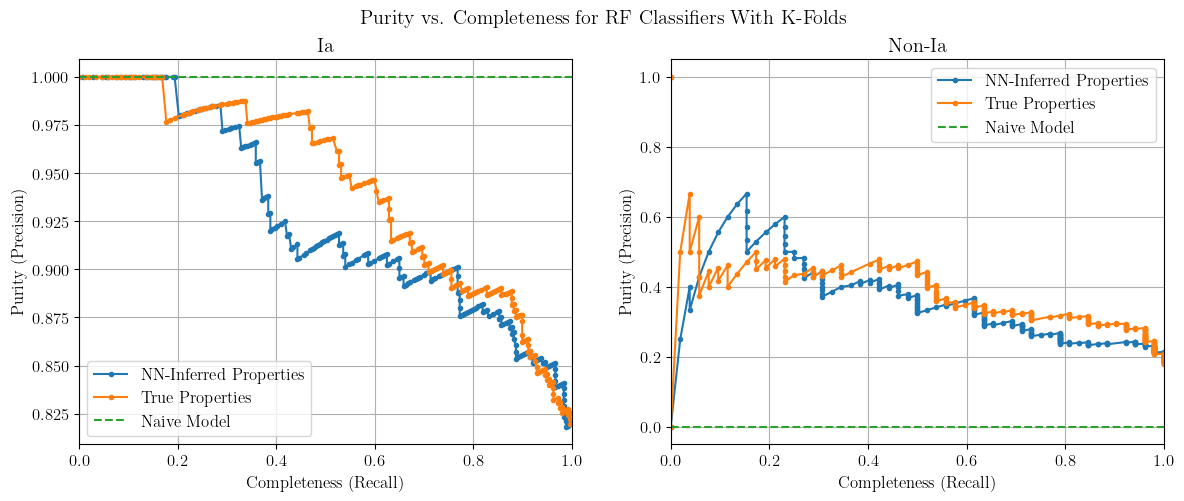

In [324]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np

# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
smote = SMOTE(random_state=22)
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=22, max_depth=best_max_depth)

# Initialize a matrix to hold the summed confusion matrix
cumulative_cm = np.array([[0, 0], [0, 0]])
cumulative_cm_true = np.array([[0, 0], [0, 0]])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests = []
y_proba = []
y_tests_true = []
y_proba_true = []

# Iterate over each sample
for indx, (train_index, test_index) in enumerate(loo.split(sne_props_X)):
    if indx%10==0:
        print(f'{indx} / {len(sne_props_X)}')

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current sample
    X_train, X_test = sne_props_X[train_index], sne_props_X[test_index]
    y_train, y_test = sne_props_y[train_index], sne_props_y[test_index]

    # Do SMOTE resampling
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Fit and get confusion matrix
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    cumulative_cm += confusion_matrix(y_test, y_pred)

    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    y_tests.append(y_test)
    y_proba.append(y_pred_proba)

    ### TRUE DERIVED DATA ###
    # Split the data into training and test sets for the current fold
    X_true_train, X_true_test = sne_props_true_X[train_index], sne_props_true_X[test_index]
    y_true_train, y_true_test = sne_props_true_y[train_index], sne_props_true_y[test_index]

    # Do SMOTE resampling
    X_true_train, y_true_train = smote.fit_resample(X_true_train, y_true_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier.fit(X_true_train, y_true_train)
    y_true_pred = rf_classifier.predict(X_true_test)
    cumulative_cm_true += confusion_matrix(y_true_test, y_true_pred)

    # Get the info for the purity vs. completeness curve
    y_pred_proba_true = rf_classifier.predict_proba(X_true_test)[:, 1]
    y_tests_true.append(y_true_test)
    y_proba_true.append(y_pred_proba_true)


# PLOTTING CONFUSION MATRICES
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cumulative_cm, ax=ax1, annot=True, fmt='d', cmap='Blues', xticklabels=['Other', 'Ia'], yticklabels=['Other', 'Ia'])
sns.heatmap(cumulative_cm_true, ax=ax2, annot=True, fmt='d', cmap='Blues', xticklabels=['Other', 'Ia'], yticklabels=['Other', 'Ia'])
ax1.set_title('RF Cumulative Confusion Matrix NN-Inferred Properties')
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax2.set_title('RF Cumulative Confusion Matrix Real Properties')
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
plt.tight_layout()
plt.show()


# PLOTTING PURITY V. COMPLETION CURVES
# Concatenate the true labels and probabilities from each fold
y_tests = np.concatenate(y_tests)
y_proba = np.concatenate(y_proba)
y_tests_true = np.concatenate(y_tests_true)
y_proba_true = np.concatenate(y_proba_true)

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_tests, y_proba)
precision_true, recall_true, thresholds_true = precision_recall_curve(y_tests_true, y_proba_true)

# Calculate precision and recall for non-Ia predictions by inverting the probabilities and labels
precision_0, recall_0, thresholds_0 = precision_recall_curve(y_tests, 1 - y_proba, pos_label=0)
precision_true_0, recall_true_0, thresholds_true_0 = precision_recall_curve(y_tests_true, 1 - y_proba_true, pos_label=0)

# Plotting purity vs. completeness
# Ia
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(recall, precision, marker='.', label='NN-Inferred Properties')
ax1.plot(recall_true, precision_true, marker='.', label='True Properties')
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax1.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Naive Model')
ax1.grid()
# Non-Ia
ax2.plot(recall_0, precision_0, marker='.', label='NN-Inferred Properties')
ax2.plot(recall_true_0, precision_true_0, marker='.', label='True Properties')
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Naive Model')
ax2.grid()

# Format
ax1.set_xlabel('Completeness (Recall)')
ax1.set_ylabel('Purity (Precision)')
ax1.set_xlim((0, 1))
plt.suptitle('Purity vs. Completeness for RF Classifiers With K-Folds')
ax1.set_title('Ia')
ax1.legend()
ax2.set_xlabel('Completeness (Recall)')
ax2.set_ylabel('Purity (Precision)')
ax2.set_xlim((0, 1))
ax2.set_title('Non-Ia')
ax2.legend()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_72237/4060300659.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_72237/4060300659.py:66: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


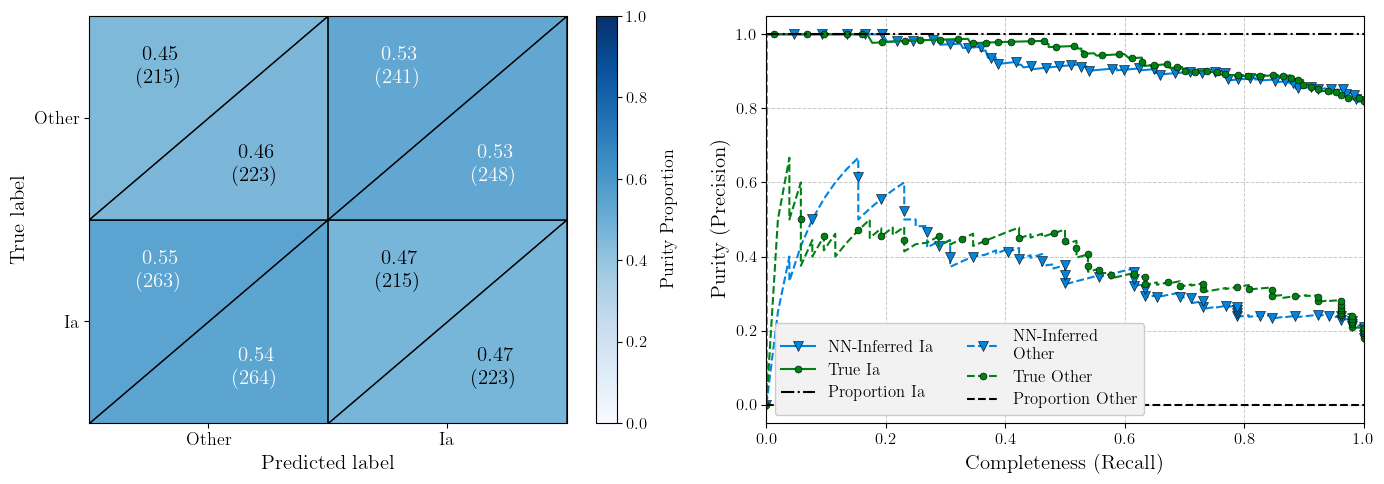

In [325]:
from matplotlib.cm import ScalarMappable

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm1 = np.flipud(cumulative_cm)
cm2 = np.flipud(cumulative_cm_true)

# Choose a colormap
cmap = plt.cm.Blues

# Define the bounds of the boxes
bounds = [0, 1, 2]

# Create a mesh grid
X, Y = np.meshgrid(bounds, bounds)

# Get the confusion normalized matrices
cm1_col_norms = np.sum(cm1, axis=0)
cm2_col_norms = np.sum(cm2, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm2_norm = cm2 / cm2_col_norms
cm1_norm = cm1_norm.round(2)
cm2_norm = cm2_norm.round(2)


# Normalize the values for the colormap
norm = plt.Normalize(vmin=0, vmax=1)

for (i, j), z in np.ndenumerate(cm1):
    # Color for the top triangle (cm1)
    color1 = cmap(norm(cm1_norm[i, j]))

    # Color for the bottom triangle (cm2)
    color2 = cmap(norm(cm2_norm[i, j]))

    # Split each cell diagonally
    ax1.fill_between([j, j+1], [i, i+1], [i+1, i+1], color=color1, edgecolor='black')
    ax1.fill_between([j, j+1], [i, i+1], [i, i], color=color2, edgecolor='black')

    # Add text
    if cm1_norm[i, j] > 0.5*norm.vmax: col1 = 'white'
    else: col1 = 'k'
    if cm1_norm[i, j] > 0.5*norm.vmax: col2 = 'white'
    else: col2 = 'k'
    ax1.text(j + 0.3, i + 0.75, '{}\n({})'.format(cm1_norm[i, j], cm1[i, j]), ha='center', va='center', fontsize=15, color=col1)
    ax1.text(j + 0.7, i + 0.27, '{}\n({})'.format(cm2_norm[i, j], cm2[i, j]), ha='center', va='center', fontsize=15, color=col1)

# Set the limits and labels
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(["Other", "Ia"])
ax1.set_yticklabels(["Ia", "Other"])
ax1.tick_params(axis='both', which='major', labelsize=13)  # Adjust labelsize as needed

# Add grid, labels and title
ax1.grid(False)
ax1.set_ylabel('True label', fontsize=15)
ax1.set_xlabel('Predicted label', fontsize=15)

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=13)



# Ia
ax2.plot(recall, precision, marker='v', label='NN-Inferred Ia', color='#0084DD', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true, precision_true, marker='.', label='True Ia', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='-.', label='Proportion Ia', color='k')
# Non-Ia
ax2.plot(recall_0, precision_0, marker='v', label='NN-Inferred \nOther', color='#0084DD', linestyle='--', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true_0, precision_true_0, marker='.', label='True Other', linestyle='--', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Proportion Other', color='k')
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)

# Format
ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.set_xlim((0, 1))
ax2.legend(fancybox=True, loc='lower left', ncol=2, framealpha=1, facecolor='#F2F2F2')
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/LOO_results.png', dpi=1000)
plt.show()

### Predicting On SEDs only

In [282]:
# Get the SEDs for all the hosts
host_seds_X = gal_props_pred_untrans[host_inds]

In [284]:
# Define the pipeline
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parameters for GridSearchCV
param_grid = {
    'classifier__max_depth': list(np.linspace(2, 31, num=30).astype(int)) + [None]  # List depths you want to test
}

# Get grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(host_seds_X, sne_props_y)
best_max_depth_seds = grid_search.best_params_['classifier__max_depth']
print("Best max depth:", best_max_depth_seds)

Best max depth: 20


In [337]:
# K fold confusion matrix
kf = StratifiedKFold(n_splits=50, random_state=22, shuffle=True)
smote = SMOTE(random_state=22)
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=22, max_depth=best_max_depth_seds)

# Initialize a matrix to hold the summed confusion matrix
cumulative_cm = np.array([[0, 0], [0, 0]])
cumulative_cm_true = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights_true = np.array([[0, 0], [0, 0]])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests = []
y_proba = []
y_tests_true = []
y_proba_true = []
f1_scores_sed = []

# Iterate over each fold
for train_index, test_index in kf.split(host_seds_X, sne_props_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = host_seds_X[train_index], host_seds_X[test_index]
    y_train, y_test = sne_props_y[train_index], sne_props_y[test_index]

    # Do SMOTE resampling
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    cumulative_cm += confusion_matrix(y_test, y_pred)
    
    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    y_tests.append(y_test)
    y_proba.append(y_pred_proba)

    # Get the f1 scores
    f1 = f1_score(y_test, y_pred, average='binary')  # Adjust the 'average' parameter as needed
    f1_scores_sed.append(f1)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_72237/4107686588.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_72237/4107686588.py:70: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


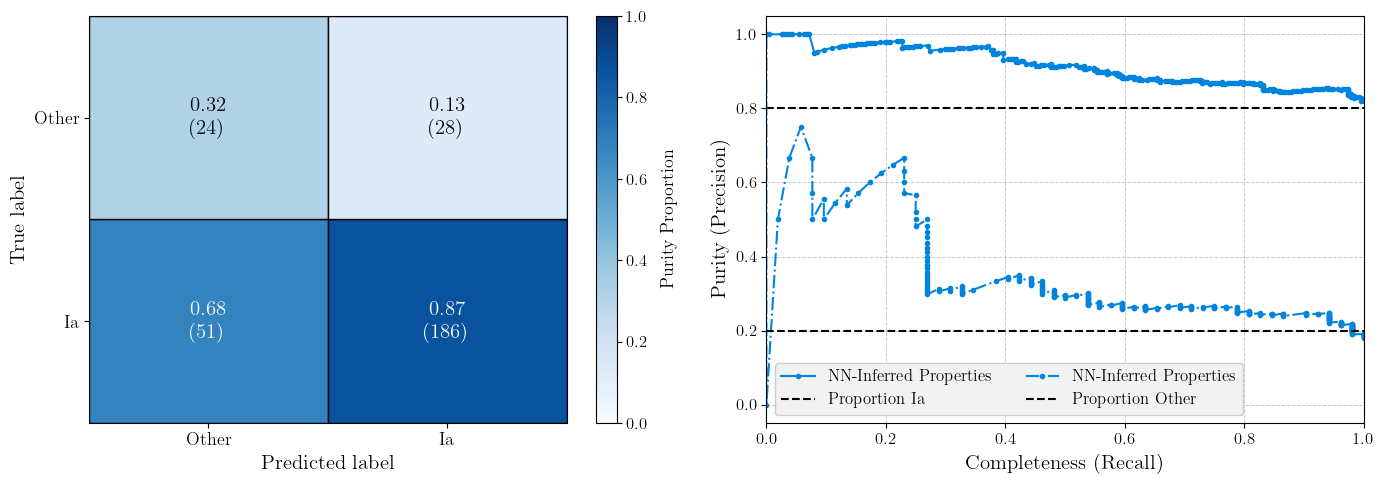

In [329]:
from matplotlib.cm import ScalarMappable

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm1 = np.flipud(cumulative_cm)

# Choose a colormap
cmap = plt.cm.Blues

# Define the bounds of the boxes
bounds = [0, 1, 2]

# Create a mesh grid
X, Y = np.meshgrid(bounds, bounds)

# Get the confusion normalized matrices
cm1_col_norms = np.sum(cm1, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm1_norm = cm1_norm.round(2)

try:
    y_tests = np.concatenate(y_tests)
    y_proba = np.concatenate(y_proba)
except:
    print('Didn\'t concat')

# Calculate precision and recall
sed_precision, sed_recall, thresholds = precision_recall_curve(y_tests, y_proba)

# Calculate precision and recall for non-Ia predictions by inverting the probabilities and labels
sed_precision_0, sed_recall_0, thresholds_0 = precision_recall_curve(y_tests, 1 - y_proba, pos_label=0)


# Normalize the values for the colormap
norm = plt.Normalize(vmin=0, vmax=1)


for (i, j), z in np.ndenumerate(cm1):
    # Color for the top triangle (cm1)
    color1 = cmap(norm(cm1_norm[i, j]))

    # Split each cell diagonally
    ax1.fill_between([j, j+1], [i, i], [i+1, i+1], color=color1, edgecolor='black')

    # Add text
    if cm1_norm[i, j] > 0.5*norm.vmax: col1 = 'white'
    else: col1 = 'k'
    if cm1_norm[i, j] > 0.5*norm.vmax: col2 = 'white'
    else: col2 = 'k'
    ax1.text(j + 0.5, i + 0.5, '{}\n({})'.format(cm1_norm[i, j], cm1[i, j]), ha='center', va='center', fontsize=15, color=col1)

# Set the limits and labels
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(["Other", "Ia"])
ax1.set_yticklabels(["Ia", "Other"])
ax1.tick_params(axis='both', which='major', labelsize=13)  # Adjust labelsize as needed

# Add grid, labels and title
ax1.grid(False)
ax1.set_ylabel('True label', fontsize=15)
ax1.set_xlabel('Predicted label', fontsize=15)

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=13)



# Ia
ax2.plot(sed_recall, sed_precision, marker='.', label='NN-Inferred Properties', color='#0084DD')
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Proportion Ia', color='k')
# Non-Ia
ax2.plot(sed_recall_0, sed_precision_0, marker='.', label='NN-Inferred Properties', color='#0084DD', linestyle='-.')
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Proportion Other', color='k')
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)

# Format
ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.set_xlim((0, 1))
ax2.legend(fancybox=True, loc='lower left', ncol=2, framealpha=1, facecolor='#F2F2F2')
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/LOO_results.png', dpi=1000)
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_72237/438499864.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_72237/438499864.py:70: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


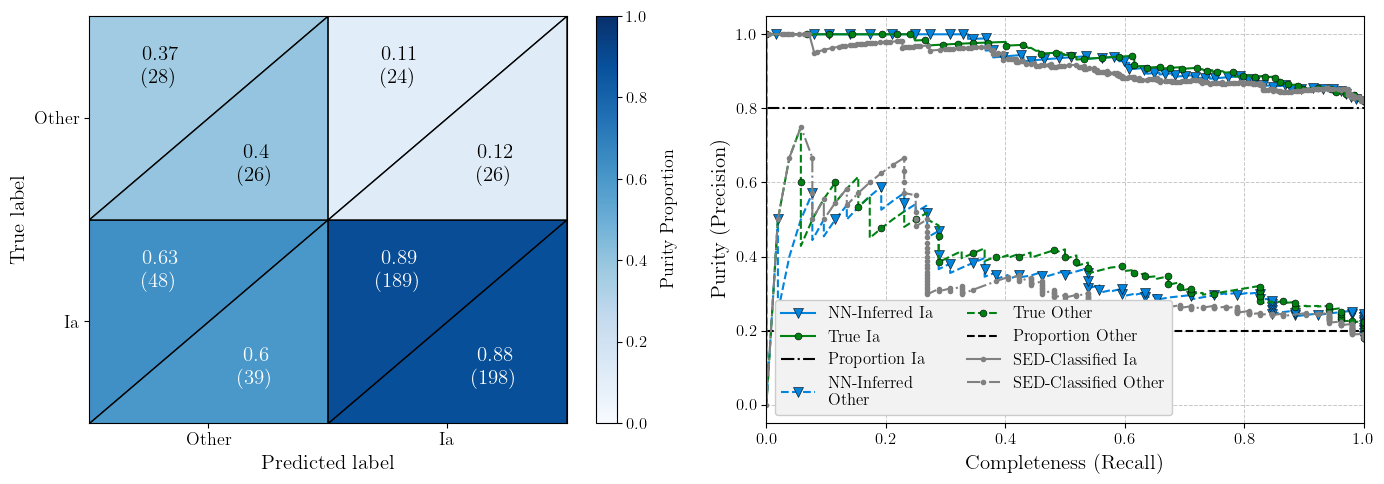

In [335]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm1 = np.flipud(cumulative_cm)
cm2 = np.flipud(cumulative_cm_true)

# Choose a colormap
cmap = plt.cm.Blues

# Define the bounds of the boxes
bounds = [0, 1, 2]

# Create a mesh grid
X, Y = np.meshgrid(bounds, bounds)

# Get the confusion normalized matrices
cm1_col_norms = np.sum(cm1, axis=0)
cm2_col_norms = np.sum(cm2, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm2_norm = cm2 / cm2_col_norms
cm1_norm = cm1_norm.round(2)
cm2_norm = cm2_norm.round(2)


# Normalize the values for the colormap
norm = plt.Normalize(vmin=0, vmax=1)


for (i, j), z in np.ndenumerate(cm1):
    # Color for the top triangle (cm1)
    color1 = cmap(norm(cm1_norm[i, j]))

    # Color for the bottom triangle (cm2)
    color2 = cmap(norm(cm2_norm[i, j]))

    # Split each cell diagonally
    # x1, y1 = i, j
    # x2, y2 = i+1, j+1
    # x3, y3 = i, j+1
    # x4, y4 = i + 1, j
    # # [x1, x3], [y1, y3], [y2, y2]
    ax1.fill_between([j, j+1], [i, i+1], [i+1, i+1], color=color1, edgecolor='black')
    ax1.fill_between([j, j+1], [i, i+1], [i, i], color=color2, edgecolor='black')

    # Add text
    if cm1_norm[i, j] > 0.5*norm.vmax: col1 = 'white'
    else: col1 = 'k'
    if cm1_norm[i, j] > 0.5*norm.vmax: col2 = 'white'
    else: col2 = 'k'
    ax1.text(j + 0.3, i + 0.75, '{}\n({})'.format(cm1_norm[i, j], cm1[i, j]), ha='center', va='center', fontsize=15, color=col1)
    ax1.text(j + 0.7, i + 0.27, '{}\n({})'.format(cm2_norm[i, j], cm2[i, j]), ha='center', va='center', fontsize=15, color=col1)

# Set the limits and labels
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(["Other", "Ia"])
ax1.set_yticklabels(["Ia", "Other"])
ax1.tick_params(axis='both', which='major', labelsize=13)  # Adjust labelsize as needed

# Add grid, labels and title
ax1.grid(False)
ax1.set_ylabel('True label', fontsize=15)
ax1.set_xlabel('Predicted label', fontsize=15)

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=13)



# Ia
ax2.plot(recall, precision, marker='v', label='NN-Inferred Ia', color='#0084DD', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true, precision_true, marker='.', label='True Ia', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='-.', label='Proportion Ia', color='k')
# Non-Ia
ax2.plot(recall_0, precision_0, marker='v', label='NN-Inferred \nOther', color='#0084DD', linestyle='--', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true_0, precision_true_0, marker='.', label='True Other', linestyle='--', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Proportion Other', color='k')
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)

# SED classifier
ax2.plot(sed_recall, sed_precision, marker='.', label='SED-Classified Ia', color='gray')
ax2.plot(sed_recall_0, sed_precision_0, marker='.', label='SED-Classified Other', color='gray', linestyle='-.')

# Format
ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.set_xlim((0, 1))
ax2.legend(fancybox=True, loc='lower left', ncol=2, framealpha=1, facecolor='#F2F2F2')
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/k_fold_results.png', dpi=1000)
plt.show()

In [342]:
# Comparing the F1 scores
print(f'F1 Scores:\n\thost-prop classifier: {np.mean(f1_scores).round(3)} +- {np.std(f1_scores).round(3)}\n\tSED classifier: {np.mean(f1_scores_sed).round(3)} +- {np.std(f1_scores_sed).round(3)}')

F1 Scores:
	host-prop classifier: 0.834 +- 0.119
	SED classifier: 0.816 +- 0.123


## Panstarrs

In [354]:
print('We seek an array with columns: \n(class, unique_identifier, angular_distance [``], mass, SRF, redshift)')
display(pd.DataFrame(sne_props))

We seek an array with columns: 
(class, unique_identifier, angular_distance [``], mass, SRF, redshift)


,0,1,2,3,4,5
0,Ia,2336057,0.037172,1.234766,-0.074488,-1.830607
1,Ia,793720,0.09511,0.38974,-0.319645,0.280461
2,Ic,1485564,0.768109,0.195903,0.27452,-0.789296
3,Ia,776283,1.502568,-0.179619,-0.283032,-0.571562
4,"Ia,Ia-91T",806358,0.309975,0.975951,0.355354,-1.367256
...,...,...,...,...,...,...
284,Ia,1956182,0.309108,0.353574,0.409997,0.230428
285,Ia,1825846,1.320941,1.793853,1.444514,0.907871
286,Ia,1780261,0.197503,0.328013,0.470056,-0.468685
287,"Ia,Ia?",2038263,0.69353,0.829192,0.572986,0.033545


In [207]:
# Get the pstar associations
panstarr_df = ascii.read("/Users/adamboesky/Research/ay98/clean_data/panstarrs_hosts.ecsv", delimiter=' ', format='ecsv')
panstarr_df: pd.DataFrame = panstarr_df.to_pandas()
panstarr_df.astype(float)
panstarr_df.replace('nan', np.nan, inplace=True)

In [208]:
# The columns of grizy mags
sed_cols = ['gKronMag_3pi','rKronMag_3pi','iKronMag_3pi','zKronMag_3pi','yKronMag_3pi']

# Drop rows where the specified columns have more than 4 NaN values
orig_len = len(panstarr_df)
panstarr_df = panstarr_df.dropna(thresh=3, subset=sed_cols, ignore_index=True)

print(f'Dropped {orig_len - len(panstarr_df)}/{orig_len} rows due to missingness.')

Dropped 885/12051 rows due to missingness.


In [391]:
sn_ra_np, sn_dec_np

(array([161.77716667, 161.42816667, 161.92058333, ...,  39.530375  ,
         78.69916667, 226.37541667]),
 array([ 0.01102778,  0.00777778, -0.23130556, ...,  1.39144444,
         7.05036111,  1.63388889]))

In [215]:
is_close = lambda a, b, thresh=1E-10: np.abs(a - b) <= thresh  # Fn for checking whether two values are close together

# Get the indices in the sne dataframe of the panstarrs info
sn_ra_np = np.array(sne_ra)
sn_dec_np = np.array(sne_dec)
pstarr_indices = []
sn_indices = []
for i, (pstar_ra, pstar_dec) in enumerate(zip(panstarr_df['SN_ra'], panstarr_df['SN_dec'])):
    if np.sum((sn_ra_np == pstar_ra) & (sn_dec_np == pstar_dec)) == 1:
        pstarr_indices.append(i)
        sn_indices.extend(np.where((sn_ra_np == pstar_ra) & (sn_dec_np == pstar_dec))[0])
print(pstarr_indices)
print(sn_indices)

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [375]:
# Get a Panstarr sne df with columns (class, ra, dec, idnex of host in pstarr_df)
pstarr_sne = sne.iloc[sn_indices][['claimedtype']]
pstarr_sne['ra'] = sn_ra_np[sn_indices]
pstarr_sne['dec'] = sn_dec_np[sn_indices]
pstarr_sne['pstarr_host_ind'] = pstarr_indices

for col in panstarr_df.columns:
    panstarr_df[col] = pd.to_numeric(panstarr_df[col], errors='coerce')

pstarr_sne['angular_separation_arcsec'] = [
    SkyCoord(ra1*u.deg, dec1*u.deg).separation(SkyCoord(ra2*u.deg, dec2*u.deg)).arcsecond
    for ra1, dec1, ra2, dec2 in zip(pstarr_sne['ra'], pstarr_sne['dec'], panstarr_df.iloc[pstarr_indices]['raStack_3pi'], panstarr_df.iloc[pstarr_indices]['decStack_3pi'])
]

# Drop rows without class
total_len = len(pstarr_sne)
pstarr_sne.dropna(subset=['claimedtype'], inplace=True)
pstarr_sne.reset_index(inplace=True, drop=True)
print(f'Dropped {total_len - len(pstarr_sne)} because not classified. Total of {len(pstarr_sne)} sne left.')

Dropped 696 because not classified. Total of 10464 sne left.


In [366]:
pstar_matched_df = pd.concat((panstarr_df.iloc[pstarr_indices].reset_index(drop=True), sne.iloc[sn_indices].reset_index(drop=True)), axis=1)
print(len(pstar_matched_df))
print(pstar_matched_df.columns)
pstar_matched_df.head()

11160
Index(['objID_3pi', 'raStack_3pi', 'decStack_3pi', 'primaryDetection_3pi',
       'gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi',
       'yKronMag_3pi', 'gKronMagErr_3pi', 'rKronMagErr_3pi', 'iKronMagErr_3pi',
       'zKronMagErr_3pi', 'yKronMagErr_3pi', 'ps_score_3pi', 'SN_ra', 'SN_dec',
       'index', 'event', 'alias', 'catalog', 'claimedtype', 'dec',
       'discoverdate', 'discoverer', 'download', 'ebv', 'host', 'hostdec',
       'hostoffsetang', 'hostoffsetdist', 'hostra', 'instruments', 'lumdist',
       'maxabsmag', 'maxappmag', 'maxdate', 'name', 'photolink', 'ra',
       'radiolink', 'redshift', 'references', 'spectralink', 'velocity',
       'xraylink'],
      dtype='object')


,objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,...,maxdate,name,photolink,ra,radiolink,redshift,references,spectralink,velocity,xraylink
0,107721619205892726,161.92064364,-0.23139161,1,22.0668,21.425,20.407,20.0965,20.1203,0.0961,...,NaN,10Z2-D,NaN,10:47:40.94,NaN,NaN,"2005A&A...430...83C,2011ApJ...737..103S",NaN,NaN,NaN
1,107712058701603113,205.87023383,-0.23935961,1,22.5147,20.9821,20.9743,20.3913,20.2973,0.091763,...,NaN,13Z3-A,NaN,13:43:28.86,NaN,NaN,"2005A&A...430...83C,2011ApJ...737..103S",NaN,NaN,NaN
2,107632063598837037,206.35988994,-0.30289261,1,20.0823,19.5422,19.0951,18.9862,19.0652,0.019853,...,NaN,13Z3-C,NaN,13:45:26.39,NaN,NaN,"2005A&A...430...83C,2011ApJ...737..103S",NaN,NaN,NaN
3,108082062811722707,206.28113041,0.06858074,1,20.4369,19.5517,19.1605,18.7795,18.885,0.031441,...,NaN,13Z3-K,NaN,13:45:07.50,NaN,NaN,"2005A&A...430...83C,2011ApJ...737..103S",NaN,NaN,NaN
4,154362201644320273,220.16438072,38.63310504,1,19.3579,17.0262,17.5039,17.6189,NaN,0.012528,...,2014/08/11,ASASSN-14fj,"1,0","14:40:39.498,14:40:39.50,14:40:39.6",NaN,0.0125,"2014ATel.6389....1N,2016A&A...594A..13P,2014AT...",NaN,3720.0,NaN


In [384]:
pstarr_ordered = panstarr_df.iloc[pstarr_indices]
pstar_photo = pstarr_ordered[['gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi',
       'yKronMag_3pi']].to_numpy()
pstar_photo_err = pstarr_ordered[['gKronMagErr_3pi', 'rKronMagErr_3pi', 'iKronMagErr_3pi',
       'zKronMagErr_3pi', 'yKronMagErr_3pi']].to_numpy()

In [385]:
# Training parameters
nodes_per_layer = [5, 6, 10, 12, 13]
num_linear_output_layers = 2
torch.set_default_dtype(torch.float64)
model = get_model(num_inputs=5, num_outputs=13, nodes_per_layer=nodes_per_layer, num_linear_output_layers=num_linear_output_layers)

# Load best model
resume(model, '/Users/adamboesky/Research/ay98/Weird_Galaxies/best_sed_model.pkl')

In [386]:
pstar_photo_norm, pstar_photo_mean, pstar_photo_std, ptar_photo_err_norm = normalize_arr(pstar_photo, errors=pstar_photo_err)